<a href="https://colab.research.google.com/github/SimoneDutto/Hate-Speech-TwitterBot/blob/master/Tesina_Data_Spaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tesina Data Spaces

> Indented block


Considerazioni: stopword, lemmatize, hashtag, multinaive, logistic regression, grammar error



```
# This is formatted as code
```

Logistic Regression, Naive Bayes, Random Forest
*   Introduction
*   Dataset
*   Preprocessing
    *   Lemmatize
    *   Hashtag analysis
    *   Mentions
    *   Grammar Error
    *   Upsampling (x)
*   Models
    *   Logistic Regression
    *   Random Forest
    *   Naive Bayes
*   Experiment
    *   Results
*   Conclusion


### Import Dataset

In [1]:
%pip install --user -U nltk
%pip install --user gingerit

     |████████████████████████████████| 1.5MB 2.7MB/s 
  Created wheel for nltk: filename=nltk-3.4.5-cp36-none-any.whl size=1449908 sha256=a21c966259f436c80abb6244d78bd6e70590cc0d8bbcfc97d7724e0fd81288f3
  Stored in directory: /root/.cache/pip/wheels/96/86/f6/68ab24c23f207c0077381a5e3904b2815136b879538a24b483
Successfully built nltk
     |████████████████████████████████| 61kB 2.0MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.21.0, but you'll have requests 2.23.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


In [2]:
from google.colab import drive
#link to download the dataset
#https://www.kaggle.com/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

drive.mount('/content/gdrive')
!7z x /content/gdrive/My\ Drive/Data\ Spaces/twitter-sentiment-analysis-hatred-speech.zip 


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/gdrive/My Drive/Data Spaces/                                               1 file, 1982527 bytes (1937 KiB)

Extracting

## Preprocessing


In [3]:
import pandas as pd
import numpy as np
df1 = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

print("Hatred labeled: {}\nNon-hatred labeled: {}".format(
    (df1.label == 1).sum(),
    (df1.label == 0).sum()
))
#Missing Values If Any
df1.isna().sum()

print(df1.iloc[:1, 0:3].head())



Hatred labeled: 2242
Non-hatred labeled: 29720
   id  label                                              tweet
0   1      0   @user when a father is dysfunctional and is s...


##Define normalization functions

In [4]:
#importing different libraries for analysis, processing and classification
import nltk
from sklearn import re #regular expression for text processing
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer #word stemmer class
lemma = WordNetLemmatizer()
# vectorizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression #classification model
from sklearn.metrics import confusion_matrix, classification_report, f1_score # performance evaluation criteria
#grammar-check
#from gingerit.gingerit import GingerIt

text = 'The smelt of fliwers bring back memories.'

nltk.download('wordnet')
nltk.download('stopwords')

stopwords = set(nltk.corpus.stopwords.words('english'))
stopwords.add('amp') #amp doesnt mean anything, it is just the formatting label

def normalizer(tweet):
    tweets = " ".join(filter(lambda x: x[0]!= '@' , tweet.split()))
    tweets = re.sub('[^a-zA-Z]', ' ', tweets)
    tweets = tweets.lower()
    tweets = tweets.split()
    tweets = [word for word in tweets if not word in stopwords]
    tweets = [lemma.lemmatize(word) for word in tweets]
    tweets = " ".join(tweets)
    return tweets

def extract_hashtag(tweet):
    tweets = " ".join(filter(lambda x: x[0]== '#', tweet.split()))
    tweets = re.sub('[^a-zA-Z]',' ',  tweets)
    tweets = tweets.lower()
    tweets = [lemma.lemmatize(word) for word in tweets]
    tweets = "".join(tweets)
    return tweets
def mentions(tweet):
    tweets = " ".join(filter(lambda x: x[0]== '@' , tweet.split()))
    return len(tweets)

# def grammar_check(tweet):
#     tweets = " ".join(filter(lambda x: x[0]!= '@' or x[0]!='#' , tweet.split()))
#     tweets = re.sub('[^a-zA-Z]', ' ', tweets)
#     tweets = tweets.lower()
#     tweets = tweets.split()
#     tweets = [word for word in tweets if not word in stopwords]
#     tweets = " ".join(tweets)
#     #print(tweets)
#     parser = GingerIt()
#     ginger_grammar_results = parser.parse(tweets)
#     #pprint.pprint(ginger_grammar_results)
#     ginger_corrections = ginger_grammar_results['corrections']
#     return int(len(ginger_corrections))


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##Apply normalization functions

In [5]:
df1['normalized_text'] = df1.tweet.apply(normalizer)
df1['hashtag'] = df1.tweet.apply(extract_hashtag)
df1['mentions'] = df1.tweet.apply(mentions)
#df1['grammar_check'] = df1.iloc[:1000].tweet.apply(grammar_check)
df1['grammar_check'] = pd.read_csv('/content/gdrive/My Drive/Data Spaces/output.csv')['grammar_check']
# print(df1['normalized_text'].head)
# print(df1['hashtag'].head())
#print(df1['mentions'].head())
#print(df1['grammar_check'].head())
#df1.to_csv('/content/gdrive/My Drive/Data Spaces/', columns = ["grammar_check"])
# print(len(df1['normalized_text']))
all_words = set(list(' '.join(df1.tweet.values).split()))
normalized = set(list(' '.join(df1.normalized_text.values).split()))
print("Unique words all_words: ", len(all_words))
print("Unique words normalized_words: ", len(normalized))

Unique words all_words:  67223
Unique words normalized_words:  35127


##Print and plot useful information about data

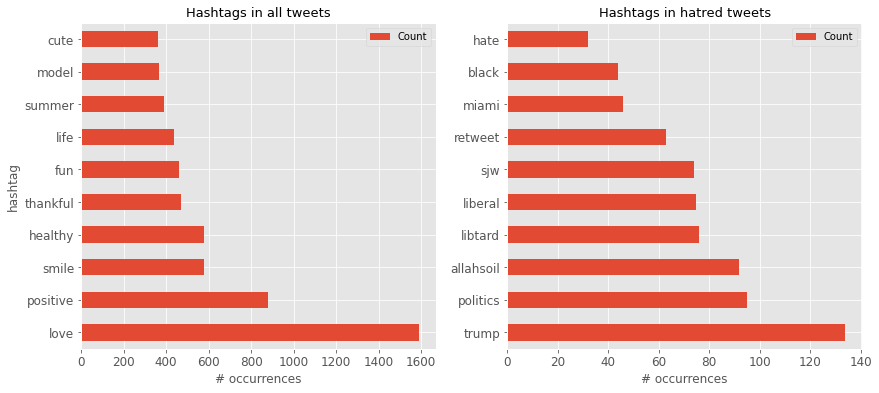

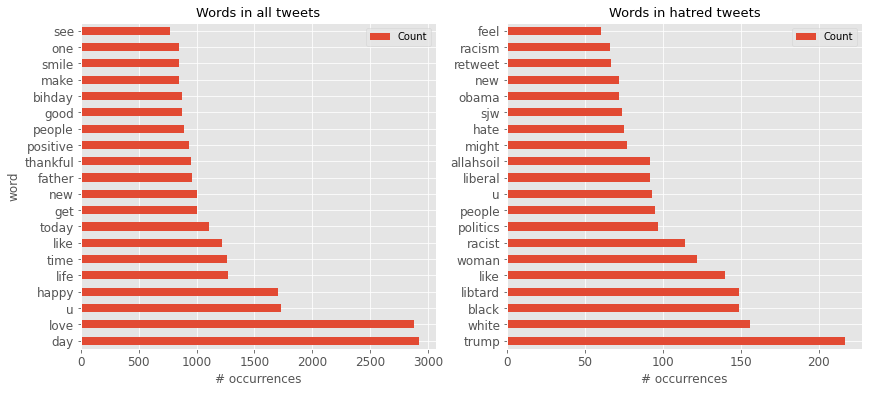

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0, flags=flags)


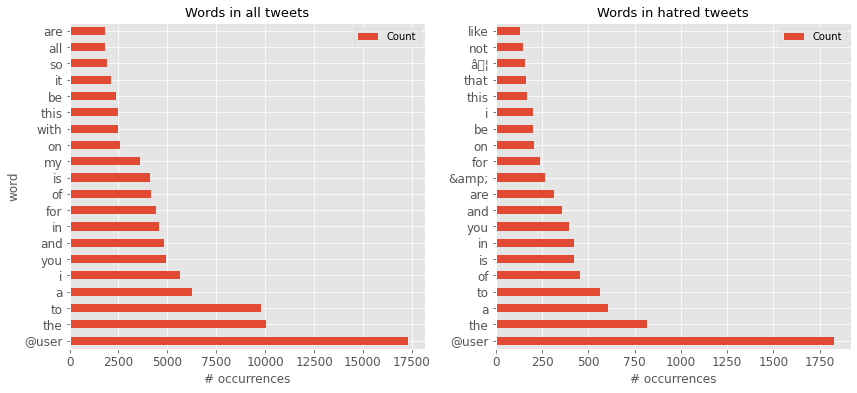

Number of mentions: 93459
Number of tweets having a mention: 11555
Correlation with label: 0.07292294681379592
Number of grammar errors: 2448.0
Number of tweets having a grammar error: 996
Correlation with label: -0.007550282679596186


In [6]:
from nltk import FreqDist 
import matplotlib.pyplot as plt
plt.style.use('ggplot')

all_hashtags = FreqDist(list(' '.join(df1.hashtag.values).split())).most_common(10)
hatred_hashtags = FreqDist(list(' '.join(df1[df1.label==1].hashtag.values).split())).most_common(10)
plt.figure(figsize=(14, 6))
ax = plt.subplot(121)
pd.DataFrame(all_hashtags, columns=['hashtag', 'Count']).set_index('hashtag').plot.barh(ax=ax, fontsize=12)
plt.xlabel('# occurrences')
plt.title('Hashtags in all tweets', size=13)
ax = plt.subplot(122)
pd.DataFrame(hatred_hashtags, columns=['hashtag', 'Count']).set_index('hashtag').plot.barh(ax=ax, fontsize=12)
plt.xlabel('# occurrences')
plt.ylabel('')
plt.title('Hashtags in hatred tweets', size=13)
plt.savefig("hashtag.png")
plt.show()
print("\n")
all_words = FreqDist(list(' '.join(df1.normalized_text.values).split())).most_common(20)
hatred_words = FreqDist(list(' '.join(df1[df1.label==1].normalized_text.values).split())).most_common(20)
plt.figure(figsize=(14, 6))
ax = plt.subplot(121)
pd.DataFrame(all_words, columns=['word', 'Count']).set_index('word').plot.barh(ax=ax, fontsize=12)
plt.xlabel('# occurrences')
plt.title('Words in all tweets', size=13)
ax = plt.subplot(122)
pd.DataFrame(hatred_words, columns=['word', 'Count']).set_index('word').plot.barh(ax=ax, fontsize=12)
plt.xlabel('# occurrences')
plt.ylabel('')
plt.title('Words in hatred tweets', size=13)
plt.savefig("allwords.png")
plt.show()
all_words = FreqDist(list(' '.join(df1.tweet.values).split())).most_common(20)
hatred_words = FreqDist(list(' '.join(df1[df1.label==1].tweet.values).split())).most_common(20)
plt.figure(figsize=(14, 6))
ax = plt.subplot(121)
pd.DataFrame(all_words, columns=['word', 'Count']).set_index('word').plot.barh(ax=ax, fontsize=12)
plt.xlabel('# occurrences')
plt.title('Words in all tweets', size=13)
ax = plt.subplot(122)
pd.DataFrame(hatred_words, columns=['word', 'Count']).set_index('word').plot.barh(ax=ax, fontsize=12)
plt.xlabel('# occurrences')
plt.ylabel('')
plt.title('Words in hatred tweets', size=13)
plt.savefig("allwords_nonorm.png")
plt.show()
print("Number of mentions: {}\nNumber of tweets having a mention: {}\nCorrelation with label: {}".format(
    df1.mentions.sum(),
    len(df1[df1.mentions > 0]),
    np.corrcoef(df1.mentions, df1.label)[0][1]
))
#print(df1['grammar_check'].iloc[:100])
print("Number of grammar errors: {}\nNumber of tweets having a grammar error: {}\nCorrelation with label: {}".format(
    df1.grammar_check.iloc[:1000].sum(),
    len(df1[df1.grammar_check > 0]),
    np.corrcoef(df1.grammar_check.iloc[:1000], df1.label.iloc[:1000])[0][1]
))
# non-relavant
df1.drop('mentions', axis=1, inplace=True)
df1.drop('grammar_check', axis=1, inplace=True)

##Define dataset train and test

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer


trainp=df1[df1['label']==1]
trainn=df1[df1['label']==0]
#print(trainp.info())
#trainn.info()

train_imbalanced = df1
from sklearn.utils import resample
df_majority = df1[df1.label==0]
df_minority = df1[df1.label==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=123) # reproducible results
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
print("Before")
print(df1.label.value_counts())
print("After")
print(df_upsampled.label.value_counts())
X_train, X_test, y_train, y_test = train_test_split(df_upsampled['normalized_text'], df_upsampled['label'], test_size=0.5, stratify=df_upsampled['label'])

vect = CountVectorizer()
tf_train=vect.fit_transform(X_train)  #train the vectorizer, build the vocablury
tf_test=vect.transform(X_test)
#print(tf_test)

# df_test['normalized_text'] = df_test.tweet.apply(normalizer)
# tf_test_nolabel=vect.transform(df_test.normalized_text)
tfidf = TfidfVectorizer(ngram_range=(1,3), min_df=10, stop_words=stopwords)

X1_train, X1_test, y1_train, y1_test = train_test_split(df_upsampled['normalized_text'], df_upsampled['label'], test_size=0.5, stratify=df_upsampled['label'])
tf1_train=tfidf.fit_transform(X1_train)  #train the vectorizer, build the vocablury
tf1_test=tfidf.transform(X1_test)

Before
0    29720
1     2242
Name: label, dtype: int64
After
1    29720
0    29720
Name: label, dtype: int64


## Initial analysis on different models

In [8]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
import time
from sklearn import svm

model = MultinomialNB()
start = time.time()
model.fit(X=tf_train,y=y_train)
stop = time.time()
print(f"Training time: {stop - start}s")
expected = y_test
start = time.time()
predicted=model.predict(tf_test)
stop = time.time()
print(f"Test time: {stop - start}s")
print(metrics.classification_report(expected, predicted))
#print(metrics.confusion_matrix(expected, predicted))

#plot_confusion_matrix(metrics.confusion_matrix(expected, predicted))
model_1 = LogisticRegression(C=10)
start = time.time()
model_1.fit(X=tf1_train,y=y1_train)
stop = time.time()
print(f"Training time: {stop - start}s")
expected1 = y1_test
start = time.time()
predicted1=model_1.predict(tf1_test)
stop = time.time()
print(f"Test time: {stop - start}s")
print(metrics.classification_report(expected1, predicted1))

model_2 = RandomForestClassifier()
start = time.time()
model_2.fit(X=tf1_train,y=y1_train)
stop = time.time()
print(f"Training time: {stop - start}s")
expected2 = y1_test
start = time.time()
predicted2=model_2.predict(tf1_test)
stop = time.time()
print(f"Test time: {stop - start}s")
print(metrics.classification_report(expected2, predicted2))

model_3 = svm.SVC(kernel='linear', C=100)
start = time.time()
model_3.fit(X=tf1_train,y=y1_train)
stop = time.time()
print(f"Training time: {stop - start}s")
expected3 = y1_test
start = time.time()
predicted3=model_3.predict(tf1_test)
stop = time.time()
print(f"Test time: {stop - start}s")
print(metrics.classification_report(expected3, predicted3))

model_4 = svm.SVC(kernel='rbf', C=100)
start = time.time()
model_4.fit(X=tf1_train,y=y1_train)
stop = time.time()
print(f"Training time: {stop - start}s")
expected4 = y1_test
start = time.time()
predicted4=model_4.predict(tf1_test)
stop = time.time()
print(f"Test time: {stop - start}s")
print(metrics.classification_report(expected4, predicted4))

Training time: 0.009082317352294922s
Test time: 0.0031926631927490234s
              precision    recall  f1-score   support

           0       0.97      0.92      0.94     14860
           1       0.92      0.97      0.95     14860

    accuracy                           0.94     29720
   macro avg       0.95      0.94      0.94     29720
weighted avg       0.95      0.94      0.94     29720



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training time: 0.5721759796142578s
Test time: 0.0016679763793945312s
              precision    recall  f1-score   support

           0       0.99      0.96      0.97     14860
           1       0.96      0.99      0.97     14860

    accuracy                           0.97     29720
   macro avg       0.97      0.97      0.97     29720
weighted avg       0.97      0.97      0.97     29720

Training time: 17.50008273124695s
Test time: 2.2800867557525635s
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     14860
           1       0.98      1.00      0.99     14860

    accuracy                           0.99     29720
   macro avg       0.99      0.99      0.99     29720
weighted avg       0.99      0.99      0.99     29720

Training time: 120.78809809684753s
Test time: 13.671132326126099s
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     14860
           1       0.95      0.99    

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       0.99      0.95      0.97     14860
           1       0.95      0.99      0.97     14860

    accuracy                           0.97     29720
   macro avg       0.97      0.97      0.97     29720
weighted avg       0.97      0.97      0.97     29720



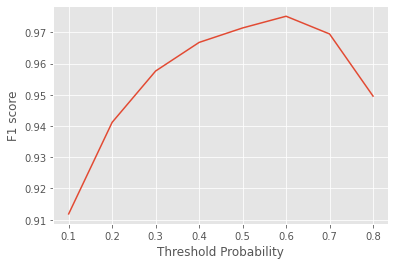

In [0]:
model_1 = LogisticRegression(C=10)
model_1.fit(X=tf1_train,y=y1_train)
expected1 = y1_test
predicted1=model_1.predict(tf1_test)
predicted1_proba = model_1.predict_proba(tf1_test)
print(metrics.classification_report(expected1, predicted1))
threshold = np.arange(0.1,0.9,0.1)
score = [f1_score(y1_test, ((predicted1_proba[:,1] >= x).astype(int))) for x in threshold]
plt.plot(threshold, score)
plt.xlabel('Threshold Probability')
plt.ylabel('F1 score')
plt.show()

## Gridsearch to fine tune models

In [0]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
import numpy as np

def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2, log=False):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    if log:
      plt.xscale('log')
    ax.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)
    ax.grid('on')


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    7.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


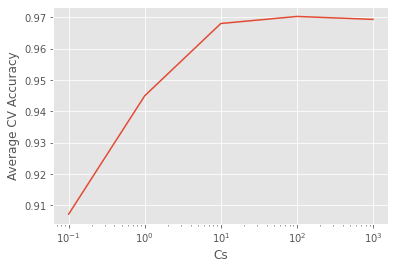

Best model on training set has {'C': 100} with accuracy 0.9703
              precision    recall  f1-score   support

           0       0.99      0.96      0.97     14860
           1       0.96      0.99      0.98     14860

    accuracy                           0.97     29720
   macro avg       0.98      0.97      0.97     29720
weighted avg       0.98      0.97      0.97     29720



In [10]:
from sklearn.metrics import recall_score, accuracy_score
accuracies=[]
recalls=[]
Cs = [0.1, 1, 10, 100, 1000]
param_grid = {'C': Cs}

clf = GridSearchCV( LogisticRegression(), param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)
    
clf.fit(tf1_train, y1_train)

plt.plot(Cs, clf.cv_results_['mean_test_score'])
plt.xlabel('Cs')
plt.xscale('log')
plt.ylabel('Average CV Accuracy')
plt.show()
print("Best model on training set has %r with accuracy %.4f" %(clf.best_params_, clf.best_score_))
y_true, y1_pred = y1_test, clf.predict(tf1_test)
print(classification_report(y_true, y1_pred))
accuracies.append(accuracy_score(y_true, y1_pred))
recalls.append(recall_score(y_true, y1_pred))

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 15.1min finished


Best model on training set has {'C': 100} with accuracy 0.9703
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     14860
           1       0.99      1.00      1.00     14860

    accuracy                           1.00     29720
   macro avg       1.00      1.00      1.00     29720
weighted avg       1.00      1.00      1.00     29720



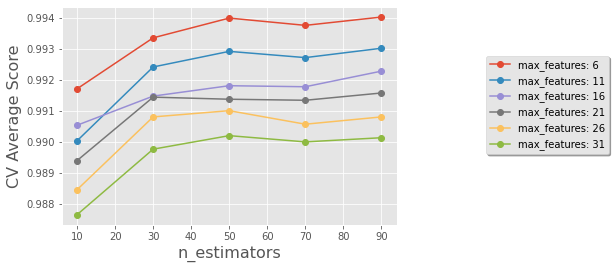

In [11]:
n_estimators = list(range(10,101,20))
max_features = list(range(6,32,5))
max_depth = list(range(6,32,5))
param_grid = {'n_estimators': n_estimators, 'max_features' : max_features}
#param_grid = {'n_estimators': n_estimators, 'max_depth' : max_depth}
clf_for = GridSearchCV(RandomForestClassifier(), param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)
    
clf_for.fit(tf1_train, y1_train)

plot_grid_search(clf_for.cv_results_, n_estimators, max_features, "n_estimators", "max_features")
#plot_grid_search(clf_for.cv_results_, n_estimators, max_depth, "n_estimators", "max_depth")

print("Best model on training set has %r with accuracy %.4f" %(clf.best_params_, clf.best_score_))
y_true, y_pred = y1_test, clf_for.predict(tf1_test)
print(classification_report(y_true, y_pred))
accuracies.append(accuracy_score(y_true, y_pred))
recalls.append(recall_score(y_true, y_pred))

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.5s finished
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


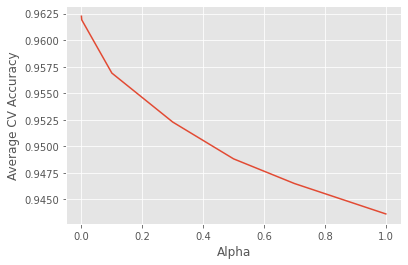

Best model on training set has {'alpha': 0} with accuracy 0.9622
              precision    recall  f1-score   support

           0       0.98      0.95      0.96     14860
           1       0.95      0.98      0.96     14860

    accuracy                           0.96     29720
   macro avg       0.96      0.96      0.96     29720
weighted avg       0.96      0.96      0.96     29720



In [12]:
alphas = [0, 0.001, 0.1,  0.3, 0.5, 0.7, 1]

param_grid = {'alpha': alphas}

clf_nai = GridSearchCV(MultinomialNB(), param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)
    
clf_nai.fit(tf_train, y_train)

plt.plot(alphas, clf_nai.cv_results_['mean_test_score'])
plt.xlabel('Alpha')
plt.ylabel('Average CV Accuracy')
plt.show()


print("Best model on training set has %r with accuracy %.4f" %(clf_nai.best_params_, clf_nai.best_score_))
y_true, y_pred = y_test, clf_nai.predict(tf_test)
print(classification_report(y_true, y_pred))
accuracies.append(accuracy_score(y_true, y_pred))
recalls.append(recall_score(y_true, y_pred))

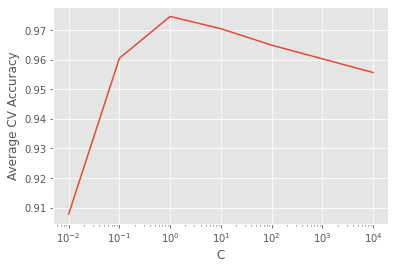

In [22]:
from sklearn import svm
Cs = [0.01, 0.1, 1, 10, 100, 10000]
param_grid = {'C': Cs}

clf_nai = GridSearchCV(svm.SVC(kernel='linear'), param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)
    
clf_nai.fit(tf_train, y_train)

plt.plot(Cs, clf_nai.cv_results_['mean_test_score'])
plt.xlabel('C')
plt.xscale('log')
plt.ylabel('Average CV Accuracy')
plt.show()

print("Best model on training set has %r with accuracy %.4f" %(clf.best_params_, clf.best_score_))
y_true, y1_pred = y1_test, clf.predict(tf1_test)
print(classification_report(y_true, y1_pred))
accuracies.append(accuracy_score(y_true, y1_pred))
recalls.append(recall_score(y_true, y1_pred))

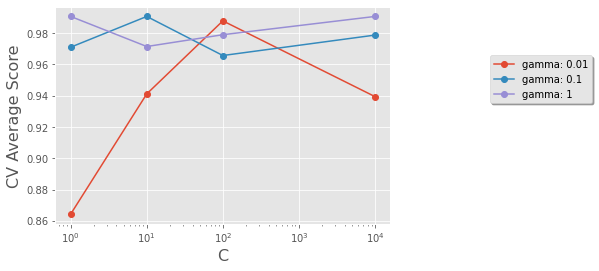

In [25]:
Cs = [1, 10, 100, 10000]
gammas = [0.01, 0.1, 1]
param_grid = {'C': Cs, 'gamma' : gammas}

#param_grid = {'n_estimators': n_estimators, 'max_depth' : max_depth}
clf_for = GridSearchCV(svm.SVC(kernel='rbf'), param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)
    
clf_for.fit(tf1_train, y1_train)

plot_grid_search(clf_for.cv_results_, Cs, gammas, "C", "gamma", True)
#plot_grid_search(clf_for.cv_results_, n_estimators, max_depth, "n_estimators", "max_depth")

print("Best model on training set has %r with accuracy %.4f" %(clf.best_params_, clf.best_score_))
y_true, y_pred = y1_test, clf_for.predict(tf1_test)
print(classification_report(y_true, y_pred))
accuracies.append(accuracy_score(y_true, y_pred))
recalls.append(recall_score(y_true, y_pred))

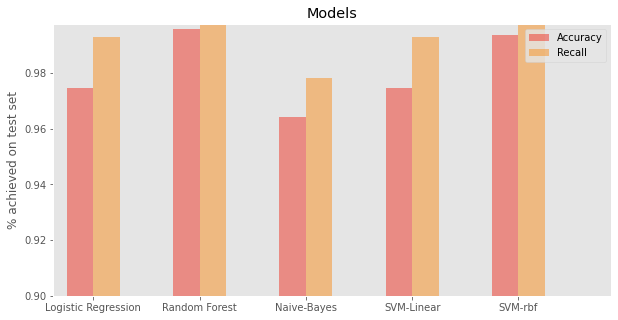

In [15]:
# Setting the positions and width for the bars
pos = list(range(len(accuracies))) 
width = 0.25 
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(10,5))

# Create a bar with pre_score data,
# in position pos,
plt.bar(pos, 
        #using df['pre_score'] data,
        accuracies, 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#EE3224', 
        # with label the first value in first_name
        label="Acc#uracy") 

# Create a bar with mid_score data,
# in position pos + some width buffer,
plt.bar([p + width for p in pos], 
        #using df['mid_score'] data,
        recalls,
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#F78F1E', 
        # with label the second value in first_name
        label="Recall") 

# Set the y axis label
ax.set_ylabel('% achieved on test set')

# Set the chart's title
ax.set_title('Models')

# Set the position of the x ticks
ax.set_xticks([p+ 0.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(["Logistic Regression","Random Forest", "Naive-Bayes", "SVM-Linear", "SVM-rbf"])

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0.9, max(accuracies + recalls)] )

# Adding the legend and showing the plot
plt.legend(['Accuracy', 'Recall'] ,loc='upper right')
plt.grid()
plt.show()